# Part 0: Data Preparation

In [29]:
!pip install datasets
!pip install nltk


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
from datasets import load_dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

# Part 1: Preparing Word Embeddings

As the first step of building your model, you need to prepare the word embeddings to form the input layer of your model. You are required to choose only from **Word2vec** or **Glove** to initialize your word embedding matrix. The word embedding matrix stores the pre-trained word vectors (taken from Word2vec or Glove) where each row corresponds to a vector for a specific word in the vocabulary formed from your task dataset.set.

In [31]:
import gensim.downloader
import matplotlib.pyplot as plt
import nltk
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from gensim.models import KeyedVectors
import gensim.downloader as api
import re
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JamesYS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Question 1. Word Embedding

### (a) What is the size of the vocabulary formed from your training data?

In [32]:
tokens = []
tokenized_sentences = [nltk.tokenize.word_tokenize(sentence['text'].lower()) for sentence in train_dataset]

for sentence in train_dataset:
    tokens.extend(nltk.tokenize.word_tokenize(sentence['text'].lower()))

print ('Number of tokens: '+ str(len(tokens)))

Number of tokens: 183968


In [33]:
word2vec_model = gensim.downloader.load('word2vec-google-news-300')
embedding_dim = word2vec_model.vector_size
print("Embedding dimension:", embedding_dim)

Embedding dimension: 300


In [34]:
# glove_file = './glove.840B.300d/glove.840B.300d.txt'  # adjust path and file name accordingly

# # Convert the GloVe format to Gensim's Word2Vec format
# glove_model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

# # Print the embedding dimension to verify
# embedding_dim = glove_model.vector_size
# print("Embedding dimension:", embedding_dim)

In [35]:
# List of all distinct words found in the tokens list
vocab = list(set(tokens))
vocab_size = len(vocab)
print ('Number of token types (Vocabulary Size): '+ str(vocab_size))

Number of token types (Vocabulary Size): 18029


(a) The size of vocabulary formed from the training data is 18029.

### (b) We use OOV (out-of-vocabulary) to refer to those words appeared in the training data but  not in the Word2vec (or Glove) dictionary. How many OOV words exist in your training data?

In [36]:
# word2vec_model = gensim.downloader.load('word2vec-google-news-300')
# embedding_dim = word2vec_model.vector_size
# print("Embedding dimension:", embedding_dim)

In [37]:
# Initialize the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
oov_words = []

# Map vocabulary to embedding matrix
word_to_idx = {word: idx for idx, word in enumerate(vocab)}

for word, idx in word_to_idx.items():
    if word in word2vec_model:
        embedding_matrix[idx] = word2vec_model[word]
    else:
        # Count OOV words
        oov_words.append(word)

# OOV words count
oov_count = len(oov_words)
print("Number of OOV words:", oov_count)

Number of OOV words: 3612


(b) There are **3612** OOV words in the training data.   

### (c) The existence of the OOV words is one of the well-known limitations of Word2vec (or Glove). Without using any transformer-based language models (e.g., BERT, GPT, T5), what do you think is the best strategy to mitigate such limitation? Implement your solution in your source code. Show the corresponding code snippet.

#### Method:BPE+Stemming

2.  Byte-Pair Encoding (BPE) and Stemming
The steps are as follows:1) 
Stemming: We utilized PorterStemmer to reduce the unknown word to its room for2) m
Subword Encoding: If the stemmed form does not match any word, we use a tokenization method “SentencePiece” to break down the word into smaller subword3) s.
Choosing the longest matching subword.


(c) To perform the Subword Encoding, we trained our SentencePiece model using text from train_dataset (Diagram 2). 

By breaking it down into subwords, BPE can handle OOV words, while stemming decreases the variety of word forms to be learned, enhancing computation efficiency
 

In [38]:
# Define a function to find replacement words based on cosine similarity
# def find_replacement_word(oov_word, model, topn=5):
#     subword_vectors = [model[word] for word in oov_word if word in model]

#     if subword_vectors:  # If there are subwords with embeddings
#         # Generate vector for OOV by averaging embeddings of subwords
#         oov_vector = np.mean(subword_vectors, axis=0)

#         # Find similar words to this estimated vector
#         similar_words = model.similar_by_vector(oov_vector, topn=topn)

#         # Return the word with highest similarity
#         return similar_words[0][0] if similar_words else None

#     return None

In [39]:
# import sentencepiece as spm
# # Load the dataset
# train_texts = dataset['train']['text']

# # Save the train texts to a file
# with open("train_texts.txt", "w",encoding="utf-8") as f:
#     for line in train_texts:
#         f.write(line + "\n")
        
# spm.SentencePieceTrainer.train(
#     input="train_texts.txt",
#     model_prefix="bpe_model",
#     vocab_size= 18029,  # Choose an appropriate size for your dataset
#     model_type="bpe"  # Specify BPE model
# )


In [40]:
# PorterStemmer method
import numpy as np
import sentencepiece as spm
from nltk.stem import PorterStemmer

def find_best_valid_subword(subwords, model):
    # Sort subwords by length descending
    sorted_subwords = sorted(subwords, key=len, reverse=True)
    # Try to find the longest subword that is in the model
    for subword in sorted_subwords:
        if subword in model:
            return subword
    # If none of the subwords are in the model, return None
    return None

def find_replacement_word(token, model, sp):
    # If the token is in the model, return it
    if token in model:
        return token

    # Initialize stemmer
    stemmer = PorterStemmer()
    stemmed_token = stemmer.stem(token)
    #print(f"Stemmed token for '{token}': {stemmed_token}")
    
    if stemmed_token in model:
        return stemmed_token

    # Encode the token to get subwords
    try:
        subwords = sp.encode(token, out_type=str)
       # print(f"Subwords for '{token}': {subwords}")
    except Exception as e:
        #print(f"Error encoding token '{token}': {e}")
        return None

    # Find the best valid subword replacement
    replacement = find_best_valid_subword(subwords, model)

    return replacement  # May return None if no valid subword is found

sp = spm.SentencePieceProcessor(model_file="bpe_model.model")

In [41]:
# # Populate embedding matrix and handle OOV words
# for word, idx in word_to_idx.items():
#     if word in word2vec_model:
#         embedding_matrix[idx] = word2vec_model[word]
#     else:
#         # Handle OOV words
#         oov_words.append(word)
#         replacement_word = find_replacement_word(word, word2vec_model)

#         if replacement_word:
#             embedding_matrix[idx] = word2vec_model[replacement_word]  # Use replacement word vector
#         else:
#             embedding_matrix[idx] = np.random.normal(size=(embedding_dim,))  # Random initialization if no replacement found

# Part 2: Model Training & Evaluation - RNN

Now with the pretrained word embeddings acquired from Part 1 and the dataset acquired from Part 0, you need to train a deep learning model for sentiment classification using the training set, conforming to these requirements:
- Use the pretrained word embeddings from Part 1 as inputs; do not update them during training (they are “frozen”).
- Design a simple recurrent neural network (RNN), taking the input word embeddings, and predicting a sentiment label for each sentence. To do that, you need to consider how to aggregate the word representations to represent a sentence.
- Use the validation set to gauge the performance of the model for each epoch during training. You are required to use **accuracy** as the performance metric during validation and evaluation.
- Use the mini-batch strategy during training. You may choose any preferred optimizer (e.g., SGD, Adagrad, Adam, RMSprop). Be careful when you choose your initial learning rate and mini-batch size. (You should use the validation set to determine the optimal configuration.) Train the model until the **accuracy** score on the validation set is not increasing for a few epochs.
- Evaluate your trained model on the test dataset, observing the **accuracy** score.

## Question 2: RNN

### (a) Report the final configuration of your best model, namely the number of training epochs, learning rate, optimizer, batch size.

### (b) Report the **accuracy** score on the test set, as well as the accuracy score on the validation  set for each epoch during training.

### (c) RNNs produce a hidden vector for each word, instead of the entire sentence. Which methods have you tried in deriving the final sentence representation to perform sentiment classification? Describe all the strategies you have implemented, together with their accuracy scores on the test set.

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence

In [43]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using device: {device}")
# device = 'cpu'

In [44]:
# Initialize an empty dictionary to store test accuracies
test_accuracies = {}

In [45]:
max_length = max(len(item) for item in tokens)

In [46]:
def prepare_data(dataset, word_to_idx, max_len):
    sequences = []
    labels = []

    for sentence in dataset:
        tokenized = nltk.tokenize.word_tokenize(sentence['text'].lower())
        indices = [word_to_idx[word] for word in tokenized if word in word_to_idx]
        sequences.append(torch.tensor(indices[:max_len]))  # Trim to max_len
        labels.append(sentence['label'])

    # Pad sequences to ensure all are the same length
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)

    # Convert labels to tensor
    labels = torch.tensor(labels)

    return padded_sequences, labels

(c) For deriving sentence representations, we implemented different strategies:
- **Last Hidden State**: Use the last hidden state of the RNN.
- **Max Pooling**: Take the maximum hidden state across all words.
- **Average Pooling**: Average the hidden states across all words.

In [47]:
class LastHiddenRNNModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(LastHiddenRNNModel, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        # Embedding layer with pretrained weights, frozen during training
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True).to(device)

        # RNN layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True).to(device)

        # Fully connected layer to predict sentiment from hidden state
        self.fc = nn.Linear(hidden_dim, output_dim).to(device)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3).to(device)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        rnn_output, hidden = self.rnn(embedded)
        # Aggregate using the last hidden state
        last_hidden = hidden[-1]
        output = self.fc(last_hidden)
        return output

class MaxPoolingRNNModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(MaxPoolingRNNModel, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        # Embedding layer with pretrained weights, frozen during training
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True).to(device)

        # RNN layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True).to(device)

        # Fully connected layer to predict sentiment from hidden state
        self.fc = nn.Linear(hidden_dim, output_dim).to(device)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3).to(device)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        rnn_output, hidden = self.rnn(embedded)
        # Max pooling over all hidden states
        max_pooled, _ = torch.max(rnn_output, dim=1)
        output = self.fc(max_pooled)
        return output

class AveragePoolingRNNModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(AveragePoolingRNNModel, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        # Embedding layer with pretrained weights, frozen during training
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True).to(device)

        # RNN layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True).to(device)

        # Fully connected layer to predict sentiment from hidden state
        self.fc = nn.Linear(hidden_dim, output_dim).to(device)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3).to(device)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        rnn_output, _ = self.rnn(embedded)

        # Average pooling over the hidden states
        mean_pooled = rnn_output.mean(dim=1)  # Take the mean across the sequence length dimension
        output = self.fc(mean_pooled)  # Pass through the fully connected layer
        return output

In [48]:
# Training function
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()  # Set model to training mode
    train_loss = 0
    train_correct = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        # Accumulate loss and accuracy
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Calculate average accuracy and loss
    train_acc = train_correct / total_train
    train_loss /= len(train_loader)  # Average loss per batch

    return train_loss, train_acc

# Validation function
def evaluate_model(model, loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total  # Return validation accuracy

# Training loop with validation
def train_model(model, train_loader, validation_loader, optimizer, criterion, epochs, patience=3):
    best_val_acc = 0
    epochs_no_improve = 0

    train_losses = []
    train_accuracies = []
    val_accuracies = []

    model = model.to(device)

    for epoch in range(epochs):
        # Training step
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation step
        val_acc = evaluate_model(model, validation_loader)
        val_accuracies.append(val_acc)

        # Print training and validation results
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        # Early stopping logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            best_model = model.state_dict()  # Save best model
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping")
            break

    model.load_state_dict(best_model)  # Load the best model weights

    return model, train_losses, train_accuracies, val_accuracies

In [49]:
# Define hyperparameter search space
learning_rates = [0.001, 0.005, 0.01, 0.1]
batch_sizes = [16, 32, 64]
optimizers = ['SGD', 'Adam', 'RMSprop']

In [50]:
def train_and_evaluate_model(model, train_loader, validation_loader, optimizer, criterion, epochs, patience):
    # Training the model (uses functions defined earlier for training and evaluation)
    model, train_losses, train_accuracies, val_accuracies = train_model(model, train_loader, validation_loader, optimizer, criterion, epochs, patience)

    # Get best validation accuracy
    best_val_acc = max(val_accuracies)

    return best_val_acc, train_losses, train_accuracies, val_accuracies

In [51]:
def run_grid_search(model_class, embedding_matrix, hidden_dim, output_dim, train_sequences, train_labels,
                    validation_sequences, validation_labels, criterion, epochs, patience):

    best_val_acc = 0
    best_hyperparams = {}

    # Prepare datasets
    train_data = TensorDataset(train_sequences.to(device), train_labels.to(device))
    validation_data = TensorDataset(validation_sequences.to(device), validation_labels.to(device))

    for lr in learning_rates:
        for batch_size in batch_sizes:
            for opt in optimizers:
                print(f"Training with lr={lr}, batch_size={batch_size}, optimizer={opt}")

                # Set up DataLoader with the current batch size
                train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
                validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

                # Initialize a new model for each set of hyperparameters
                model = model_class(embedding_matrix=embedding_matrix, hidden_dim=hidden_dim, output_dim=output_dim)  # Reinitialize model
                model = model.to(device)

                # Choose optimizer
                if opt == 'SGD':
                    optimizer = optim.SGD(model.parameters(), lr=lr)
                elif opt == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                elif opt == 'RMSprop':
                    optimizer = optim.RMSprop(model.parameters(), lr=lr)

                # Train and evaluate the model
                val_acc, _, _, _ = train_and_evaluate_model(model, train_loader, validation_loader, optimizer, criterion, epochs, patience)


                # Track the best configuration based on validation accuracy
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_hyperparams = {'lr': lr, 'batch_size': batch_size, 'optimizer': opt}

    print(f"Best Validation Accuracy: {best_val_acc}")
    print(f"Best Hyperparameters: {best_hyperparams}")

    return best_hyperparams

In [52]:
# Prepare the train, validation, and test datasets
train_sequences, train_labels = prepare_data(train_dataset, word_to_idx, max_length)
validation_sequences, validation_labels = prepare_data(validation_dataset, word_to_idx, max_length)
test_sequences, test_labels = prepare_data(test_dataset, word_to_idx, max_length)

In [53]:
train_sequences = train_sequences.to(device)
train_labels = train_labels.to(device)
validation_sequences = validation_sequences.to(device)
validation_labels = validation_labels.to(device)
test_sequences = test_sequences.to(device)
test_labels = test_labels.to(device)

In [54]:
# Plot accuracy scores
def plot_metrics(epochs, train_losses, train_accuracies, val_accuracies):
    # Epochs range
    epoch_range = range(1, epochs + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_range, train_losses, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Epoch vs Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epoch_range, train_accuracies, label='Train Accuracy')
    plt.plot(epoch_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Epoch vs Accuracy')
    plt.legend()

    # Show plots
    plt.tight_layout()
    plt.show()

In [55]:
# Model parameters
hidden_dim = 256
output_dim = 2  # Binary classification: positive/negative

# Define loss function, and other constants
criterion = nn.CrossEntropyLoss()
epochs = 20
patience = 3  # Early stopping patience

### 1) RNN Last Hidden State

In [56]:
# Call grid search
best_hyperparams_RNN_last = run_grid_search(LastHiddenRNNModel, embedding_matrix, hidden_dim, output_dim, train_sequences, train_labels,
                                            validation_sequences, validation_labels, criterion, epochs, patience)

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6942, Train Acc: 0.4980, Val Acc: 0.5028
Epoch 2, Train Loss: 0.6943, Train Acc: 0.4940, Val Acc: 0.4934
Epoch 3, Train Loss: 0.6941, Train Acc: 0.4954, Val Acc: 0.4934
Epoch 4, Train Loss: 0.6953, Train Acc: 0.4939, Val Acc: 0.5047
Epoch 5, Train Loss: 0.6941, Train Acc: 0.5004, Val Acc: 0.5047
Epoch 6, Train Loss: 0.6934, Train Acc: 0.5054, Val Acc: 0.4925
Epoch 7, Train Loss: 0.6933, Train Acc: 0.5035, Val Acc: 0.5056
Epoch 8, Train Loss: 0.6943, Train Acc: 0.4984, Val Acc: 0.4916
Epoch 9, Train Loss: 0.6938, Train Acc: 0.5038, Val Acc: 0.5066
Epoch 10, Train Loss: 0.6943, Train Acc: 0.4975, Val Acc: 0.5066
Epoch 11, Train Loss: 0.6936, Train Acc: 0.5059, Val Acc: 0.5066
Epoch 12, Train Loss: 0.6938, Train Acc: 0.5015, Val Acc: 0.5066
Early stopping
Training with lr=0.001, batch_size=16, optimizer=Adam
Epoch 1, Train Loss: 0.7078, Train Acc: 0.4974, Val Acc: 0.4859
Epoch 2, Train Loss: 0.7086, Train Acc: 0.4

In [57]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_RNN_last['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [58]:
# Retrain using best hyperparameters
best_model_RNN_last = LastHiddenRNNModel(embedding_matrix, hidden_dim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_RNN_last['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_RNN_last.parameters(), lr=best_hyperparams_RNN_last['lr'])
elif best_hyperparams_RNN_last['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_RNN_last.parameters(), lr=best_hyperparams_RNN_last['lr'])
elif best_hyperparams_RNN_last['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_RNN_last.parameters(), lr=best_hyperparams_RNN_last['lr'])

best_model_RNN_last, train_losses, train_accuracies, val_accuracies = train_model(best_model_RNN_last, train_loader, validation_loader,
                                                                                  best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.7197, Train Acc: 0.5072, Val Acc: 0.4709
Epoch 2, Train Loss: 0.7056, Train Acc: 0.4965, Val Acc: 0.4991
Epoch 3, Train Loss: 0.7083, Train Acc: 0.5106, Val Acc: 0.4962
Epoch 4, Train Loss: 0.7096, Train Acc: 0.4994, Val Acc: 0.4878
Epoch 5, Train Loss: 0.7092, Train Acc: 0.5043, Val Acc: 0.4859
Early stopping


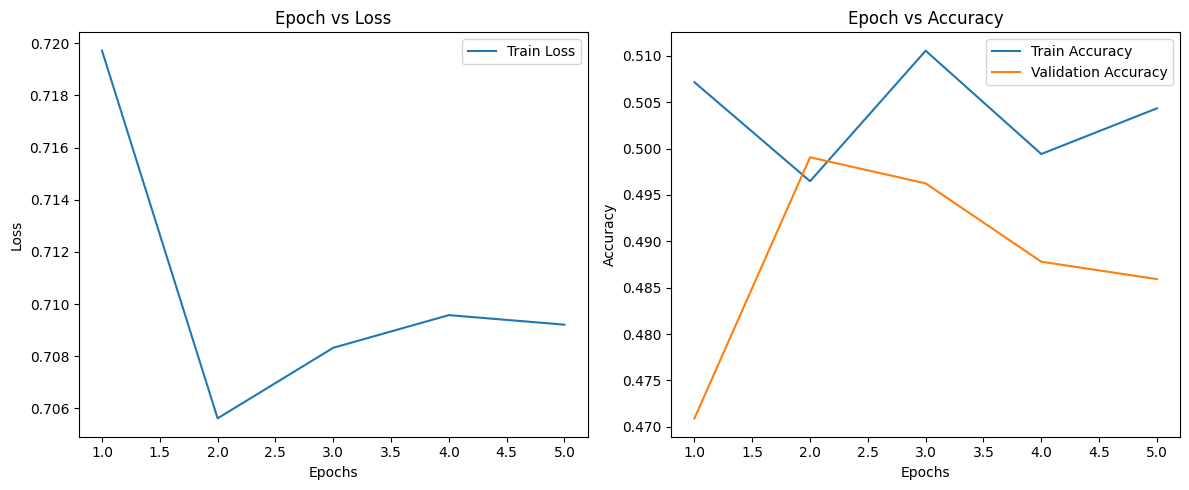

In [59]:
epochs_LHS = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs_LHS, train_losses, train_accuracies, val_accuracies)

In [60]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_RNN_last, test_loader)
test_accuracies['RNN Last Hidden State'] = test_acc
print(f'Test Accuracy (RNN Last Hidden State): {test_acc:.4f}')

Test Accuracy (RNN Last Hidden State): 0.4991


### 2) RNN Max Pooling

In [61]:
# Call grid search
best_hyperparams_RNN_max = run_grid_search(MaxPoolingRNNModel, embedding_matrix, hidden_dim, output_dim, train_sequences, train_labels,
                                           validation_sequences, validation_labels, criterion, epochs, patience)

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6946, Train Acc: 0.4902, Val Acc: 0.5075
Epoch 2, Train Loss: 0.6944, Train Acc: 0.4873, Val Acc: 0.5159
Epoch 3, Train Loss: 0.6934, Train Acc: 0.5077, Val Acc: 0.5178
Epoch 4, Train Loss: 0.6927, Train Acc: 0.5113, Val Acc: 0.5281
Epoch 5, Train Loss: 0.6924, Train Acc: 0.5175, Val Acc: 0.5169
Epoch 6, Train Loss: 0.6916, Train Acc: 0.5215, Val Acc: 0.5478
Epoch 7, Train Loss: 0.6914, Train Acc: 0.5285, Val Acc: 0.5629
Epoch 8, Train Loss: 0.6908, Train Acc: 0.5392, Val Acc: 0.5169
Epoch 9, Train Loss: 0.6899, Train Acc: 0.5485, Val Acc: 0.5938
Epoch 10, Train Loss: 0.6894, Train Acc: 0.5472, Val Acc: 0.5450
Epoch 11, Train Loss: 0.6887, Train Acc: 0.5660, Val Acc: 0.6051
Epoch 12, Train Loss: 0.6880, Train Acc: 0.5659, Val Acc: 0.6210
Epoch 13, Train Loss: 0.6875, Train Acc: 0.5729, Val Acc: 0.6229
Epoch 14, Train Loss: 0.6866, Train Acc: 0.5862, Val Acc: 0.6023
Epoch 15, Train Loss: 0.6854, Train Acc: 0.606

In [62]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_RNN_max['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [63]:
# Retrain using best hyperparameters
best_model_RNN_max = MaxPoolingRNNModel(embedding_matrix, hidden_dim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_RNN_max['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_RNN_max.parameters(), lr=best_hyperparams_RNN_max['lr'])
elif best_hyperparams_RNN_max['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_RNN_max.parameters(), lr=best_hyperparams_RNN_max['lr'])
elif best_hyperparams_RNN_max['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_RNN_max.parameters(), lr=best_hyperparams_RNN_max['lr'])

best_model_RNN_max, train_losses, train_accuracies, val_accuracies = train_model(best_model_RNN_max, train_loader, validation_loader,
                                                                                 best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.6656, Train Acc: 0.5825, Val Acc: 0.6557
Epoch 2, Train Loss: 0.5315, Train Acc: 0.7329, Val Acc: 0.7589
Epoch 3, Train Loss: 0.4785, Train Acc: 0.7722, Val Acc: 0.7814
Epoch 4, Train Loss: 0.4493, Train Acc: 0.7904, Val Acc: 0.7711
Epoch 5, Train Loss: 0.4357, Train Acc: 0.7965, Val Acc: 0.7467
Epoch 6, Train Loss: 0.4126, Train Acc: 0.8114, Val Acc: 0.7833
Epoch 7, Train Loss: 0.3904, Train Acc: 0.8264, Val Acc: 0.7758
Epoch 8, Train Loss: 0.3664, Train Acc: 0.8374, Val Acc: 0.7627
Epoch 9, Train Loss: 0.3613, Train Acc: 0.8368, Val Acc: 0.7852
Epoch 10, Train Loss: 0.3392, Train Acc: 0.8545, Val Acc: 0.7749
Epoch 11, Train Loss: 0.3212, Train Acc: 0.8628, Val Acc: 0.7871
Epoch 12, Train Loss: 0.2981, Train Acc: 0.8716, Val Acc: 0.7852
Epoch 13, Train Loss: 0.2989, Train Acc: 0.8672, Val Acc: 0.7842
Epoch 14, Train Loss: 0.2658, Train Acc: 0.8863, Val Acc: 0.7326
Early stopping


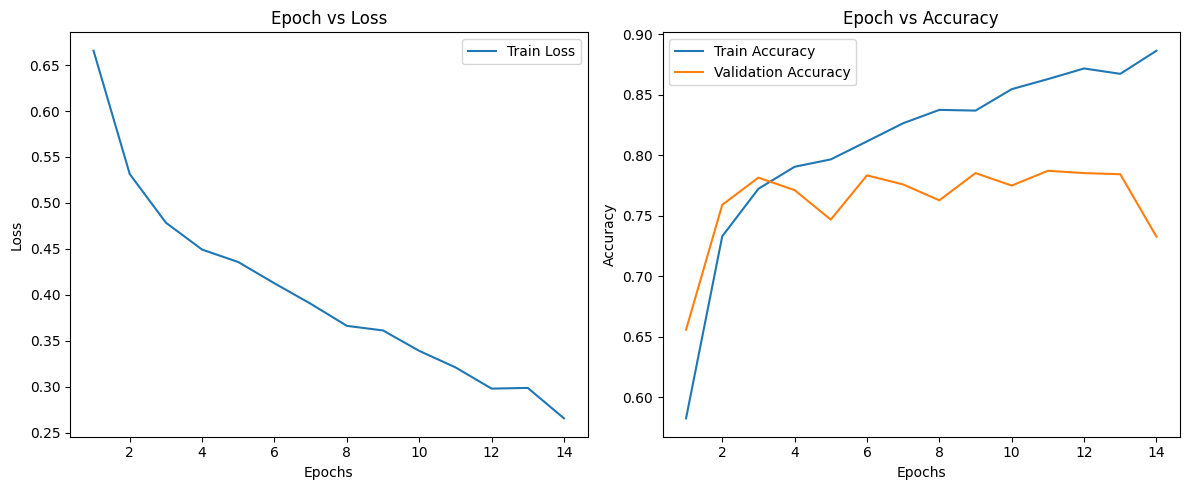

In [64]:
epochs_max = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs_max, train_losses, train_accuracies, val_accuracies)

In [65]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_RNN_max, test_loader)
test_accuracies['RNN Max Pooling'] = test_acc
print(f'Test Accuracy (RNN Max Pooling): {test_acc:.4f}')

Test Accuracy (RNN Max Pooling): 0.7570


### 3) RNN Average Pooling

In [66]:
# Call grid search
best_hyperparams_RNN_avg = run_grid_search(AveragePoolingRNNModel, embedding_matrix, hidden_dim, output_dim, train_sequences, train_labels,
                                   validation_sequences, validation_labels, criterion, epochs, patience)

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6932, Train Acc: 0.5011, Val Acc: 0.5328
Epoch 2, Train Loss: 0.6928, Train Acc: 0.5098, Val Acc: 0.5394
Epoch 3, Train Loss: 0.6925, Train Acc: 0.5234, Val Acc: 0.5478
Epoch 4, Train Loss: 0.6922, Train Acc: 0.5401, Val Acc: 0.5600
Epoch 5, Train Loss: 0.6922, Train Acc: 0.5351, Val Acc: 0.5638
Epoch 6, Train Loss: 0.6920, Train Acc: 0.5299, Val Acc: 0.5385
Epoch 7, Train Loss: 0.6917, Train Acc: 0.5377, Val Acc: 0.5206
Epoch 8, Train Loss: 0.6916, Train Acc: 0.5522, Val Acc: 0.5863
Epoch 9, Train Loss: 0.6913, Train Acc: 0.5489, Val Acc: 0.5610
Epoch 10, Train Loss: 0.6911, Train Acc: 0.5560, Val Acc: 0.5835
Epoch 11, Train Loss: 0.6910, Train Acc: 0.5701, Val Acc: 0.6257
Epoch 12, Train Loss: 0.6907, Train Acc: 0.5750, Val Acc: 0.5779
Epoch 13, Train Loss: 0.6906, Train Acc: 0.5878, Val Acc: 0.6257
Epoch 14, Train Loss: 0.6902, Train Acc: 0.5880, Val Acc: 0.5854
Early stopping
Training with lr=0.001, batch_s

In [67]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_RNN_avg['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [68]:
# Retrain using best hyperparameters
best_model_RNN_avg = AveragePoolingRNNModel(embedding_matrix, hidden_dim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_RNN_avg['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_RNN_avg.parameters(), lr=best_hyperparams_RNN_avg['lr'])
elif best_hyperparams_RNN_avg['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_RNN_avg.parameters(), lr=best_hyperparams_RNN_avg['lr'])
elif best_hyperparams_RNN_avg['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_RNN_avg.parameters(), lr=best_hyperparams_RNN_avg['lr'])

best_model_RNN_avg, train_losses, train_accuracies, val_accuracies = train_model(best_model_RNN_avg, train_loader, validation_loader,
                                                                                 best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.7092, Train Acc: 0.5116, Val Acc: 0.4981
Epoch 2, Train Loss: 0.6930, Train Acc: 0.5034, Val Acc: 0.5019
Epoch 3, Train Loss: 0.6913, Train Acc: 0.5292, Val Acc: 0.5319
Epoch 4, Train Loss: 0.6807, Train Acc: 0.5743, Val Acc: 0.5657
Epoch 5, Train Loss: 0.6222, Train Acc: 0.6578, Val Acc: 0.5694
Epoch 6, Train Loss: 0.5884, Train Acc: 0.6947, Val Acc: 0.7101
Epoch 7, Train Loss: 0.5902, Train Acc: 0.6988, Val Acc: 0.7270
Epoch 8, Train Loss: 0.5816, Train Acc: 0.7082, Val Acc: 0.7233
Epoch 9, Train Loss: 0.5713, Train Acc: 0.7157, Val Acc: 0.7064
Epoch 10, Train Loss: 0.5571, Train Acc: 0.7242, Val Acc: 0.6904
Early stopping


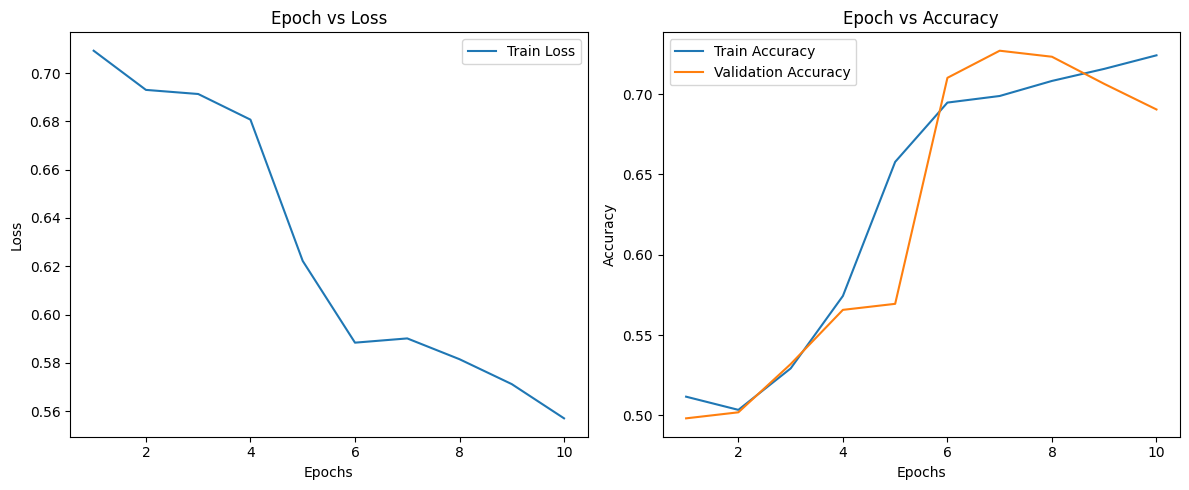

In [69]:
epochs_avg = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs_avg, train_losses, train_accuracies, val_accuracies)

In [70]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_RNN_avg, test_loader)
test_accuracies['RNN Average Pooling'] = test_acc
print(f'Test Accuracy (RNN Average Pooling): {test_acc:.4f}')

Test Accuracy (RNN Average Pooling): 0.7054


In [71]:
test_accuracies

{'RNN Last Hidden State': 0.49906191369606,
 'RNN Max Pooling': 0.7570356472795498,
 'RNN Average Pooling': 0.7054409005628518}

**Max pooling** achieved the highest test accuracy of 0.7923.    
Thus, in the following sectinos we will apply max pooling to derive the final sentence representation to perform sentiment classification.

# Part 3: Enhancement

The RNN model used in Part 2 is a basic model to perform the task of sentiment classification. In  this section, you will design strategies to improve upon the previous model you have built. You ar
 required to implement the following adjustments:

1. Instead of keeping the word embeddings fixed, now update the word embeddings (the same way as model parameters) during the training process.
2. As discussed in Question 1(c), apply your solution in mitigating the influence of OOV words and train your model again.
3. Keeping the above two adjustments, replace your simple RNN model in Part 2 with a biLSTM model and a biGRU model, incorporating recurrent computations in both directions and stacking multiple layers if possible.
4. Keeping the above two adjustments, replace your simple RNN model in Part 2 with a Convolutional Neural Network (CNN) to produce sentence representations and perform sentiment classification.
5. Further improve your model. You are free to use any strategy other than the above mentioned solutions. Changing hyper-parameters or stacking more layers is not counted towards a meaningful improvement.

## Question 3: Enhancement

### (a) Report the accuracy score on the test set when the word embeddings are updated (Part 3.1).

Set `freeze=False` when initializing the embedding layer to allow word embeddings update.

In [72]:
class MaxPoolingRNNModelUpdate(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(MaxPoolingRNNModelUpdate, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape

        # Embedding layer with pretrained weights, frozen during training
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False).to(device)

        # RNN layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True).to(device)

        # Fully connected layer to predict sentiment from hidden state
        self.fc = nn.Linear(hidden_dim, output_dim).to(device)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3).to(device)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        rnn_output, hidden = self.rnn(embedded)
        # Max pooling over all hidden states
        max_pooled, _ = torch.max(rnn_output, dim=1)
        output = self.fc(max_pooled)
        return output

In [73]:
# Model parameters
hidden_dim = 256
output_dim = 2  # Binary classification: positive/negative

# Define loss function, and other constants
criterion = nn.CrossEntropyLoss()
epochs = 20
patience = 3  # Early stopping patience

# Call grid search
best_hyperparams_RNN_update = run_grid_search(MaxPoolingRNNModelUpdate, embedding_matrix, hidden_dim, output_dim, train_sequences, train_labels,
                                   validation_sequences, validation_labels, criterion, epochs, patience)

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6948, Train Acc: 0.5111, Val Acc: 0.4991
Epoch 2, Train Loss: 0.6915, Train Acc: 0.5244, Val Acc: 0.5516
Epoch 3, Train Loss: 0.6901, Train Acc: 0.5336, Val Acc: 0.5779
Epoch 4, Train Loss: 0.6904, Train Acc: 0.5335, Val Acc: 0.5882
Epoch 5, Train Loss: 0.6899, Train Acc: 0.5542, Val Acc: 0.6041
Epoch 6, Train Loss: 0.6892, Train Acc: 0.5494, Val Acc: 0.5966
Epoch 7, Train Loss: 0.6880, Train Acc: 0.5555, Val Acc: 0.6182
Epoch 8, Train Loss: 0.6879, Train Acc: 0.5680, Val Acc: 0.6341
Epoch 9, Train Loss: 0.6870, Train Acc: 0.5771, Val Acc: 0.6004
Epoch 10, Train Loss: 0.6853, Train Acc: 0.5934, Val Acc: 0.6370
Epoch 11, Train Loss: 0.6846, Train Acc: 0.5899, Val Acc: 0.5854
Epoch 12, Train Loss: 0.6839, Train Acc: 0.6011, Val Acc: 0.6379
Epoch 13, Train Loss: 0.6821, Train Acc: 0.6018, Val Acc: 0.6520
Epoch 14, Train Loss: 0.6811, Train Acc: 0.6229, Val Acc: 0.6820
Epoch 15, Train Loss: 0.6793, Train Acc: 0.630

In [74]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_RNN_update['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [75]:
# Retrain using best hyperparameters
best_model_RNN_update = MaxPoolingRNNModelUpdate(embedding_matrix, hidden_dim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_RNN_update['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_RNN_update.parameters(), lr=best_hyperparams_RNN_update['lr'])
elif best_hyperparams_RNN_update['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_RNN_update.parameters(), lr=best_hyperparams_RNN_update['lr'])
elif best_hyperparams_RNN_update['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_RNN_update.parameters(), lr=best_hyperparams_RNN_update['lr'])

best_model_RNN_update, train_losses, train_accuracies, val_accuracies = train_model(best_model_RNN_update, train_loader, validation_loader,
                                                                                    best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.5331, Train Acc: 0.7291, Val Acc: 0.7908
Epoch 2, Train Loss: 0.3530, Train Acc: 0.8448, Val Acc: 0.7871
Epoch 3, Train Loss: 0.2451, Train Acc: 0.9002, Val Acc: 0.7777
Epoch 4, Train Loss: 0.1677, Train Acc: 0.9365, Val Acc: 0.7720
Early stopping


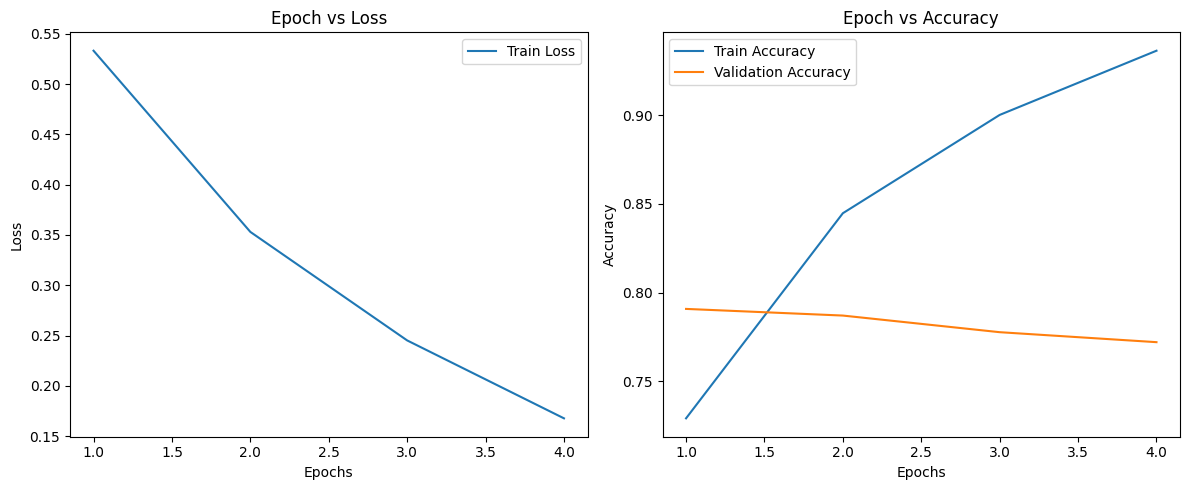

In [76]:
epochs_mp = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs_mp, train_losses, train_accuracies, val_accuracies)

In [77]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_RNN_update, test_loader)
test_accuracies['RNN (Update Word Embeddings)'] = test_acc
print(f'Test Accuracy (Update Word Embeddings): {test_acc:.4f}')

Test Accuracy (Update Word Embeddings): 0.7964


### (b) Report the accuracy score on the test set when applying your method to deal with OOV words in Part 3.2.

In [78]:
# # Initialize the embedding matrix
# embedding_matrix_cosine_sim = np.zeros((vocab_size, embedding_dim))

# # Map vocabulary to embedding matrix
# word_to_idx = {word: idx for idx, word in enumerate(vocab)}

# # Populate embedding matrix and handle OOV words
# for word, idx in word_to_idx.items():
#     if word in word2vec_model:
#         embedding_matrix_cosine_sim[idx] = word2vec_model[word]
#     else:
#         # Handle OOV words
#         replacement_word = find_replacement_word(word, word2vec_model)

#         if replacement_word:
#             embedding_matrix_cosine_sim[idx] = word2vec_model[replacement_word]  # Use replacement word vector
#         else:
#             embedding_matrix_cosine_sim[idx] = np.random.normal(size=(embedding_dim,))  # Random initialization if no replacement found

In [79]:
# Initialize the embedding matrix
embedding_matrix_cosine_sim = np.zeros((vocab_size, embedding_dim))

# Map vocabulary to embedding matrix
word_to_idx = {word: idx for idx, word in enumerate(vocab)}

# Populate embedding matrix and handle OOV words
for word, idx in word_to_idx.items():
    if word in word2vec_model:
        embedding_matrix_cosine_sim[idx] = word2vec_model[word]
    else:
        # Handle OOV words
        # replacement_word = find_replacement_word(word, glove_model)
        replacement_word = find_replacement_word(word, word2vec_model, sp)
        if replacement_word:
            embedding_matrix_cosine_sim[idx] = word2vec_model[replacement_word]  # Use replacement word vector
        else:
            embedding_matrix_cosine_sim[idx] = np.random.normal(size=(embedding_dim,))  # Random initialization if no replacement found

In [80]:
# Model parameters
hidden_dim = 256
output_dim = 2  # Binary classification: positive/negative

# Define loss function, and other constants
criterion = nn.CrossEntropyLoss()
epochs = 20
patience = 3  # Early stopping patience

### 1) Freeze Word Embeddings

In [81]:
# Call grid search
best_hyperparams_OOV_freeze = run_grid_search(MaxPoolingRNNModel, embedding_matrix_cosine_sim, hidden_dim, output_dim, train_sequences, train_labels,
                                              validation_sequences, validation_labels, criterion, epochs, patience)

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6942, Train Acc: 0.5203, Val Acc: 0.5300
Epoch 2, Train Loss: 0.6886, Train Acc: 0.5404, Val Acc: 0.5432
Epoch 3, Train Loss: 0.6859, Train Acc: 0.5540, Val Acc: 0.5375
Epoch 4, Train Loss: 0.6849, Train Acc: 0.5537, Val Acc: 0.5394
Epoch 5, Train Loss: 0.6851, Train Acc: 0.5553, Val Acc: 0.5629
Epoch 6, Train Loss: 0.6853, Train Acc: 0.5477, Val Acc: 0.5600
Epoch 7, Train Loss: 0.6840, Train Acc: 0.5513, Val Acc: 0.5535
Epoch 8, Train Loss: 0.6834, Train Acc: 0.5596, Val Acc: 0.5572
Early stopping
Training with lr=0.001, batch_size=16, optimizer=Adam
Epoch 1, Train Loss: 0.6933, Train Acc: 0.5462, Val Acc: 0.5657
Epoch 2, Train Loss: 0.6778, Train Acc: 0.5739, Val Acc: 0.5779
Epoch 3, Train Loss: 0.6683, Train Acc: 0.5877, Val Acc: 0.5957
Epoch 4, Train Loss: 0.6502, Train Acc: 0.6137, Val Acc: 0.6295
Epoch 5, Train Loss: 0.6263, Train Acc: 0.6436, Val Acc: 0.5966
Epoch 6, Train Loss: 0.5898, Train Acc: 0.6872

In [82]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_OOV_freeze['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [83]:
# Retrain using best hyperparameters
best_model_OOV_freeze = MaxPoolingRNNModel(embedding_matrix_cosine_sim, hidden_dim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_OOV_freeze['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_OOV_freeze.parameters(), lr=best_hyperparams_OOV_freeze['lr'])
elif best_hyperparams_OOV_freeze['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_OOV_freeze.parameters(), lr=best_hyperparams_OOV_freeze['lr'])
elif best_hyperparams_OOV_freeze['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_OOV_freeze.parameters(), lr=best_hyperparams_OOV_freeze['lr'])

best_model_OOV_freeze, train_losses, train_accuracies, val_accuracies = train_model(best_model_OOV_freeze, train_loader, validation_loader,
                                                                                    best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.6893, Train Acc: 0.5478, Val Acc: 0.5647
Epoch 2, Train Loss: 0.6300, Train Acc: 0.6345, Val Acc: 0.6088
Epoch 3, Train Loss: 0.5507, Train Acc: 0.7168, Val Acc: 0.7373
Epoch 4, Train Loss: 0.5265, Train Acc: 0.7361, Val Acc: 0.7448
Epoch 5, Train Loss: 0.5122, Train Acc: 0.7457, Val Acc: 0.7467
Epoch 6, Train Loss: 0.4963, Train Acc: 0.7591, Val Acc: 0.7364
Epoch 7, Train Loss: 0.4955, Train Acc: 0.7590, Val Acc: 0.7289
Epoch 8, Train Loss: 0.4751, Train Acc: 0.7693, Val Acc: 0.7589
Epoch 9, Train Loss: 0.4690, Train Acc: 0.7735, Val Acc: 0.7598
Epoch 10, Train Loss: 0.4635, Train Acc: 0.7785, Val Acc: 0.7711
Epoch 11, Train Loss: 0.4502, Train Acc: 0.7846, Val Acc: 0.7448
Epoch 12, Train Loss: 0.4378, Train Acc: 0.7920, Val Acc: 0.7692
Epoch 13, Train Loss: 0.4292, Train Acc: 0.7988, Val Acc: 0.7664
Early stopping


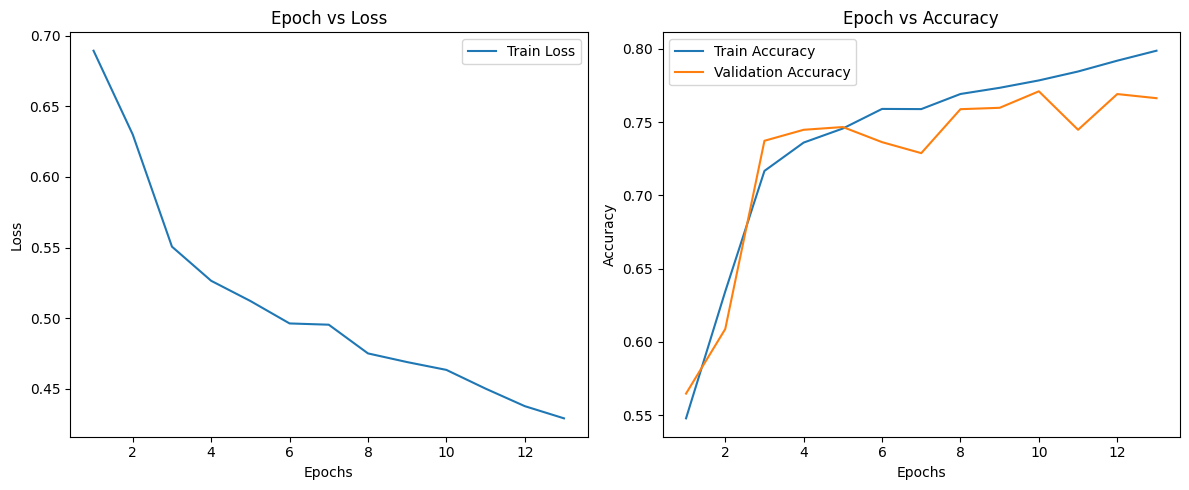

In [84]:
epochs_fw = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs_fw, train_losses, train_accuracies, val_accuracies)

In [85]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_OOV_freeze, test_loader)
test_accuracies['RNN (Handle OOV)'] = test_acc
print(f'Test Accuracy (Handle OOV): {test_acc:.4f}')

Test Accuracy (Handle OOV): 0.7589


### 2) Update Word Embeddings

In [86]:
# Call grid search
best_hyperparams_OOV_update = run_grid_search(MaxPoolingRNNModelUpdate, embedding_matrix_cosine_sim, hidden_dim, output_dim, train_sequences, train_labels,
                                   validation_sequences, validation_labels, criterion, epochs, patience)

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6903, Train Acc: 0.5343, Val Acc: 0.5235
Epoch 2, Train Loss: 0.6869, Train Acc: 0.5471, Val Acc: 0.5300
Epoch 3, Train Loss: 0.6865, Train Acc: 0.5437, Val Acc: 0.5460
Epoch 4, Train Loss: 0.6857, Train Acc: 0.5531, Val Acc: 0.5403
Epoch 5, Train Loss: 0.6854, Train Acc: 0.5518, Val Acc: 0.5338
Epoch 6, Train Loss: 0.6836, Train Acc: 0.5544, Val Acc: 0.5516
Epoch 7, Train Loss: 0.6843, Train Acc: 0.5538, Val Acc: 0.5460
Epoch 8, Train Loss: 0.6819, Train Acc: 0.5586, Val Acc: 0.5432
Epoch 9, Train Loss: 0.6821, Train Acc: 0.5623, Val Acc: 0.5544
Epoch 10, Train Loss: 0.6825, Train Acc: 0.5562, Val Acc: 0.5469
Epoch 11, Train Loss: 0.6821, Train Acc: 0.5547, Val Acc: 0.5460
Epoch 12, Train Loss: 0.6816, Train Acc: 0.5579, Val Acc: 0.5516
Early stopping
Training with lr=0.001, batch_size=16, optimizer=Adam
Epoch 1, Train Loss: 0.6821, Train Acc: 0.5644, Val Acc: 0.5704
Epoch 2, Train Loss: 0.5081, Train Acc: 0.7

In [87]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_OOV_update['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [88]:
# Retrain using best hyperparameters
best_model_OOV_update = MaxPoolingRNNModelUpdate(embedding_matrix_cosine_sim, hidden_dim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_OOV_update['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_OOV_update.parameters(), lr=best_hyperparams_OOV_update['lr'])
elif best_hyperparams_OOV_update['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_OOV_update.parameters(), lr=best_hyperparams_OOV_update['lr'])
elif best_hyperparams_OOV_update['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_OOV_update.parameters(), lr=best_hyperparams_OOV_update['lr'])

best_model_OOV_update, train_losses, train_accuracies, val_accuracies = train_model(best_model_OOV_update, train_loader, validation_loader,
                                                                                    best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.7042, Train Acc: 0.5467, Val Acc: 0.6370
Epoch 2, Train Loss: 0.5571, Train Acc: 0.7118, Val Acc: 0.6914
Epoch 3, Train Loss: 0.4057, Train Acc: 0.8149, Val Acc: 0.7795
Epoch 4, Train Loss: 0.3111, Train Acc: 0.8647, Val Acc: 0.7833
Epoch 5, Train Loss: 0.2434, Train Acc: 0.9006, Val Acc: 0.6088
Epoch 6, Train Loss: 0.1885, Train Acc: 0.9290, Val Acc: 0.6032
Epoch 7, Train Loss: 0.1427, Train Acc: 0.9464, Val Acc: 0.7664
Early stopping


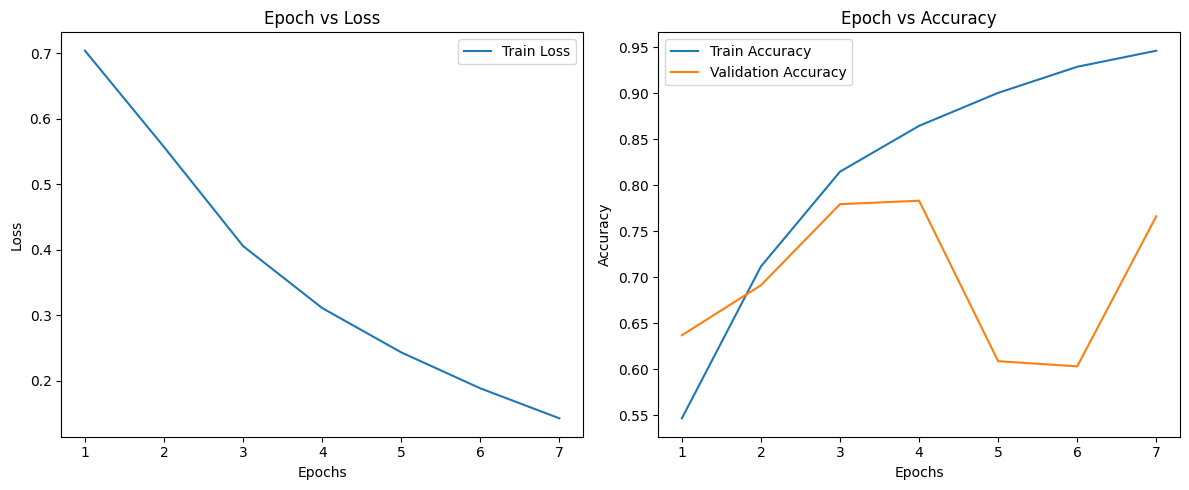

In [89]:
epochs_w = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs_w, train_losses, train_accuracies, val_accuracies)

In [90]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_OOV_update, test_loader)
test_accuracies['RNN (Handle OOV with Word Embeddings Update)'] = test_acc
print(f'Test Accuracy (Handle OOV with Word Embeddings Update): {test_acc:.4f}')

Test Accuracy (Handle OOV with Word Embeddings Update): 0.7636


### (c) Report the accuracy scores of biLSTM and biGRU on the test set (Part 3.3).

In [91]:
# Define BiLSTM and BiGRU models
class BiLSTMModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(BiLSTMModel, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False).to(device)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True).to(device)
        self.fc = nn.Linear(hidden_dim * 2, output_dim).to(device)  # Multiplied by 2 for bidirection
        self.dropout = nn.Dropout(0.3).to(device)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        lstm_output, _ = self.lstm(embedded)  # Shape: [batch_size, seq_len, hidden_dim * 2]
        # Apply max pooling over the output of the LSTM
        max_pooled, _ = torch.max(lstm_output, dim=1)  # Shape: [batch_size, hidden_dim * 2]
        output = self.fc(max_pooled)
        return output

class BiGRUModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim):
        super(BiGRUModel, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False).to(device)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True).to(device)
        self.fc = nn.Linear(hidden_dim * 2, output_dim).to(device)  # Multiplied by 2 for bidirection
        self.dropout = nn.Dropout(0.3).to(device)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        gru_output, _ = self.gru(embedded)  # Shape: [batch_size, seq_len, hidden_dim * 2]
        # Apply max pooling over the output of the GRU
        max_pooled, _ = torch.max(gru_output, dim=1)  # Shape: [batch_size, hidden_dim * 2]
        output = self.fc(max_pooled)
        return output

In [92]:
# Model parameters
hidden_dim = 256
output_dim = 2  # Binary classification: positive/negative

# Define loss function, and other constants
criterion = nn.CrossEntropyLoss()
epochs = 20
patience = 3  # Early stopping patience

### 1) biLSTM

In [93]:
# Call grid search
best_hyperparams_biLSTM = run_grid_search(BiLSTMModel, embedding_matrix_cosine_sim, hidden_dim, output_dim, train_sequences, train_labels,
                                          validation_sequences, validation_labels, criterion, epochs, patience)

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6938, Train Acc: 0.5117, Val Acc: 0.5084
Epoch 2, Train Loss: 0.6917, Train Acc: 0.5220, Val Acc: 0.5235
Epoch 3, Train Loss: 0.6900, Train Acc: 0.5342, Val Acc: 0.5310
Epoch 4, Train Loss: 0.6892, Train Acc: 0.5420, Val Acc: 0.5366
Epoch 5, Train Loss: 0.6881, Train Acc: 0.5557, Val Acc: 0.5394
Epoch 6, Train Loss: 0.6875, Train Acc: 0.5477, Val Acc: 0.5263
Epoch 7, Train Loss: 0.6857, Train Acc: 0.5544, Val Acc: 0.5441
Epoch 8, Train Loss: 0.6858, Train Acc: 0.5517, Val Acc: 0.5488
Epoch 9, Train Loss: 0.6852, Train Acc: 0.5576, Val Acc: 0.5432
Epoch 10, Train Loss: 0.6844, Train Acc: 0.5603, Val Acc: 0.5413
Epoch 11, Train Loss: 0.6843, Train Acc: 0.5570, Val Acc: 0.5525
Epoch 12, Train Loss: 0.6838, Train Acc: 0.5647, Val Acc: 0.5535
Epoch 13, Train Loss: 0.6827, Train Acc: 0.5617, Val Acc: 0.5516
Epoch 14, Train Loss: 0.6835, Train Acc: 0.5619, Val Acc: 0.5516
Epoch 15, Train Loss: 0.6824, Train Acc: 0.561

In [94]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_biLSTM['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [95]:
# Retrain using best hyperparameters
best_model_biLSTM = BiLSTMModel(embedding_matrix_cosine_sim, hidden_dim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_biLSTM['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_biLSTM.parameters(), lr=best_hyperparams_biLSTM['lr'])
elif best_hyperparams_biLSTM['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_biLSTM.parameters(), lr=best_hyperparams_biLSTM['lr'])
elif best_hyperparams_biLSTM['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_biLSTM.parameters(), lr=best_hyperparams_biLSTM['lr'])

best_model_biLSTM, train_losses, train_accuracies, val_accuracies = train_model(best_model_biLSTM, train_loader, validation_loader,
                                                                                best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.6196, Train Acc: 0.6581, Val Acc: 0.7636
Epoch 2, Train Loss: 0.3554, Train Acc: 0.8448, Val Acc: 0.7674
Epoch 3, Train Loss: 0.2308, Train Acc: 0.9041, Val Acc: 0.7739
Epoch 4, Train Loss: 0.1477, Train Acc: 0.9422, Val Acc: 0.7758
Epoch 5, Train Loss: 0.0906, Train Acc: 0.9665, Val Acc: 0.7786
Epoch 6, Train Loss: 0.0530, Train Acc: 0.9812, Val Acc: 0.7645
Epoch 7, Train Loss: 0.0335, Train Acc: 0.9885, Val Acc: 0.7598
Epoch 8, Train Loss: 0.0257, Train Acc: 0.9904, Val Acc: 0.7720
Early stopping


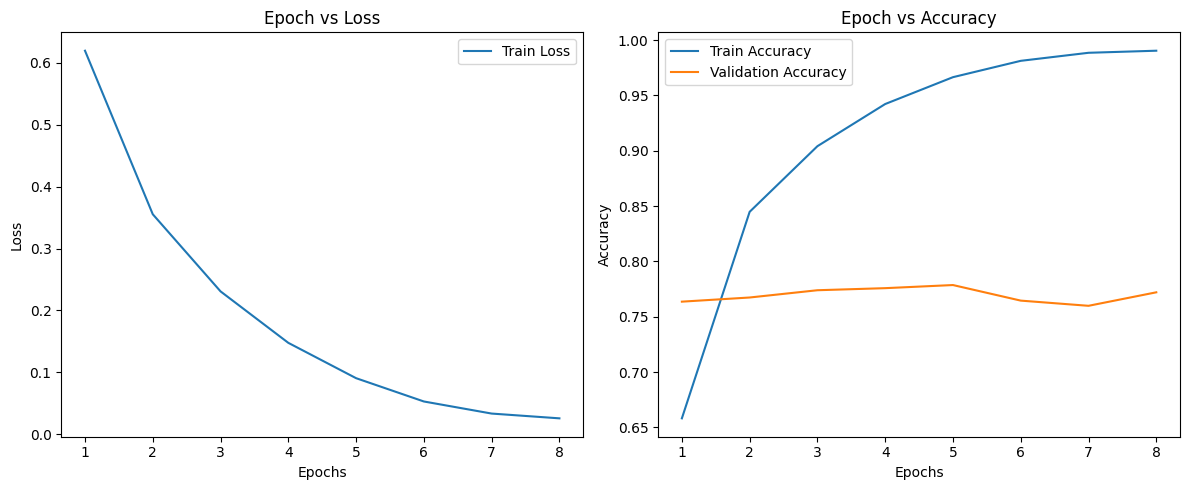

In [96]:
epochs_bi = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs_bi, train_losses, train_accuracies, val_accuracies)

In [97]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_biLSTM, test_loader)
test_accuracies['biLSTM'] = test_acc
print(f'Test Accuracy (biLSTM): {test_acc:.4f}')

Test Accuracy (biLSTM): 0.7917


### 2) biGRU

In [98]:
# Call grid search
best_hyperparams_biGRU = run_grid_search(BiGRUModel, embedding_matrix_cosine_sim, hidden_dim, output_dim, train_sequences, train_labels,
                                         validation_sequences, validation_labels, criterion, epochs, patience)

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.6915, Train Acc: 0.5192, Val Acc: 0.5432
Epoch 2, Train Loss: 0.6896, Train Acc: 0.5366, Val Acc: 0.5469
Epoch 3, Train Loss: 0.6859, Train Acc: 0.5490, Val Acc: 0.5563
Epoch 4, Train Loss: 0.6852, Train Acc: 0.5573, Val Acc: 0.5516
Epoch 5, Train Loss: 0.6836, Train Acc: 0.5572, Val Acc: 0.5525
Epoch 6, Train Loss: 0.6825, Train Acc: 0.5578, Val Acc: 0.5600
Epoch 7, Train Loss: 0.6831, Train Acc: 0.5596, Val Acc: 0.5544
Epoch 8, Train Loss: 0.6820, Train Acc: 0.5579, Val Acc: 0.5525
Epoch 9, Train Loss: 0.6812, Train Acc: 0.5648, Val Acc: 0.5525
Early stopping
Training with lr=0.001, batch_size=16, optimizer=Adam
Epoch 1, Train Loss: 0.5608, Train Acc: 0.6968, Val Acc: 0.7636
Epoch 2, Train Loss: 0.3168, Train Acc: 0.8612, Val Acc: 0.7720
Epoch 3, Train Loss: 0.1451, Train Acc: 0.9440, Val Acc: 0.7645
Epoch 4, Train Loss: 0.0621, Train Acc: 0.9792, Val Acc: 0.7580
Epoch 5, Train Loss: 0.0270, Train Acc: 0.9917

In [99]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_biGRU['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [100]:
# Retrain using best hyperparameters
best_model_biGRU = BiGRUModel(embedding_matrix_cosine_sim, hidden_dim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_biGRU['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_biGRU.parameters(), lr=best_hyperparams_biGRU['lr'])
elif best_hyperparams_biGRU['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_biGRU.parameters(), lr=best_hyperparams_biGRU['lr'])
elif best_hyperparams_biGRU['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_biGRU.parameters(), lr=best_hyperparams_biGRU['lr'])

best_model_biGRU, train_losses, train_accuracies, val_accuracies = train_model(best_model_biGRU, train_loader, validation_loader,
                                                                               best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.7124, Train Acc: 0.5667, Val Acc: 0.5760
Epoch 2, Train Loss: 0.5888, Train Acc: 0.6875, Val Acc: 0.6811
Epoch 3, Train Loss: 0.5066, Train Acc: 0.7508, Val Acc: 0.6820
Epoch 4, Train Loss: 0.4668, Train Acc: 0.7725, Val Acc: 0.7786
Epoch 5, Train Loss: 0.4230, Train Acc: 0.8039, Val Acc: 0.6914
Epoch 6, Train Loss: 0.3987, Train Acc: 0.8200, Val Acc: 0.6773
Epoch 7, Train Loss: 0.3731, Train Acc: 0.8333, Val Acc: 0.7767
Early stopping


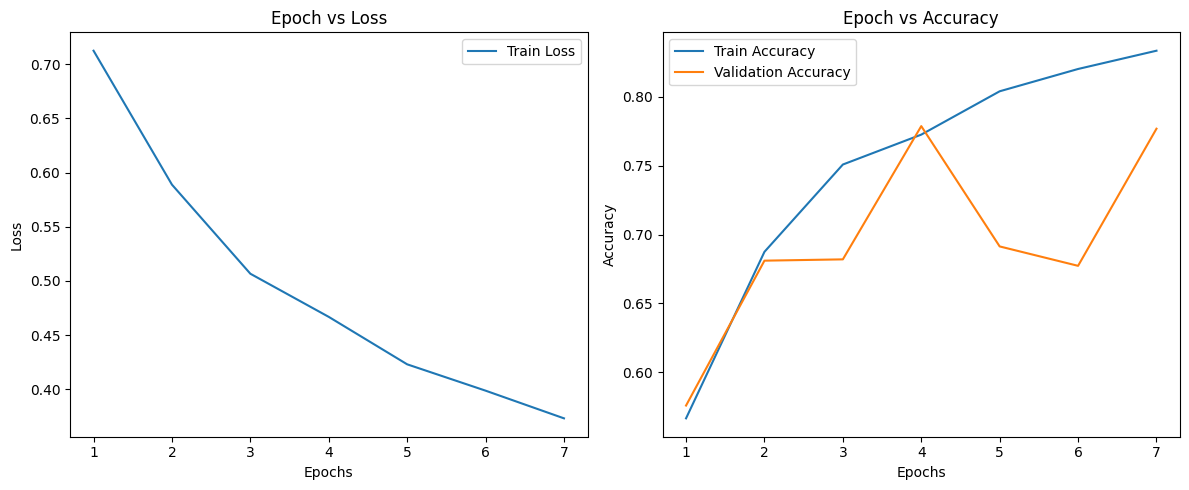

In [101]:
epochs_big = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs_big, train_losses, train_accuracies, val_accuracies)

In [102]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_biGRU, test_loader)
test_accuracies['biGRU'] = test_acc
print(f'Test Accuracy (biGRU): {test_acc:.4f}')

Test Accuracy (biGRU): 0.8030


### (d) Report the accuracy scores of CNN on the test set (Part 3.4).

In [103]:
# Define CNN Model
class CNNModel(nn.Module):
    def __init__(self, embedding_matrix, output_dim):
        super(CNNModel, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False).to(device)
        self.conv1 = nn.Conv2d(1, 100, (3, embedding_dim)).to(device)  # 1 input channel, 100 output channels
        self.fc = nn.Linear(100, output_dim).to(device)
        self.dropout = nn.Dropout(0.3).to(device)

    def forward(self, x):
        embedded = self.embedding(x).unsqueeze(1)  # Add channel dimension
        conv_out = self.conv1(embedded).squeeze(3)  # Shape: (batch_size, 100, sequence_length - filter_size + 1)
        conv_out = torch.relu(conv_out)  # Apply ReLU
        pooled = nn.functional.max_pool1d(conv_out, conv_out.size(2)).squeeze(2)  # Max pooling
        output = self.fc(self.dropout(pooled))
        return output

In [104]:
# Model parameters
hidden_dim = 256
output_dim = 2  # Binary classification: positive/negative

# Define loss function, and other constants
criterion = nn.CrossEntropyLoss()
epochs = 20
patience = 3  # Early stopping patience

In [105]:
best_val_acc = 0
best_hyperparams_CNN = {}

# Prepare datasets
train_data = TensorDataset(train_sequences.to(device), train_labels.to(device))
validation_data = TensorDataset(validation_sequences.to(device), validation_labels.to(device))

# Grid search
for lr in learning_rates:
    for batch_size in batch_sizes:
        for opt in optimizers:
            print(f"Training with lr={lr}, batch_size={batch_size}, optimizer={opt}")

            # Set up DataLoader with the current batch size
            train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

            # Initialize a new model for each set of hyperparameters
            model = CNNModel(embedding_matrix=embedding_matrix_cosine_sim, output_dim=output_dim)  # Reinitialize model
            model = model.to(device)

            # Choose optimizer
            if opt == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=lr)
            elif opt == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=lr)
            elif opt == 'RMSprop':
                optimizer = optim.RMSprop(model.parameters(), lr=lr)

            # Train and evaluate the model
            val_acc, _, _, _ = train_and_evaluate_model(model, train_loader, validation_loader, optimizer, criterion, epochs, patience)


            # Track the best configuration based on validation accuracy
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_hyperparams = {'lr': lr, 'batch_size': batch_size, 'optimizer': opt}

print(f"Best Validation Accuracy: {best_val_acc}")
print(f"Best Hyperparameters: {best_hyperparams}")

Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1, Train Loss: 0.7032, Train Acc: 0.5175, Val Acc: 0.5600
Epoch 2, Train Loss: 0.6907, Train Acc: 0.5512, Val Acc: 0.5525
Epoch 3, Train Loss: 0.6862, Train Acc: 0.5535, Val Acc: 0.5525
Epoch 4, Train Loss: 0.6831, Train Acc: 0.5583, Val Acc: 0.5647
Epoch 5, Train Loss: 0.6800, Train Acc: 0.5634, Val Acc: 0.5591
Epoch 6, Train Loss: 0.6774, Train Acc: 0.5687, Val Acc: 0.5610
Epoch 7, Train Loss: 0.6766, Train Acc: 0.5763, Val Acc: 0.5722
Epoch 8, Train Loss: 0.6759, Train Acc: 0.5770, Val Acc: 0.5769
Epoch 9, Train Loss: 0.6736, Train Acc: 0.5753, Val Acc: 0.5619
Epoch 10, Train Loss: 0.6716, Train Acc: 0.5887, Val Acc: 0.5629
Epoch 11, Train Loss: 0.6701, Train Acc: 0.5836, Val Acc: 0.5685
Early stopping
Training with lr=0.001, batch_size=16, optimizer=Adam
Epoch 1, Train Loss: 0.6660, Train Acc: 0.6028, Val Acc: 0.7233
Epoch 2, Train Loss: 0.4402, Train Acc: 0.8011, Val Acc: 0.7467
Epoch 3, Train Loss: 0.2430, Train Acc: 0.90

In [106]:
best_hyperparams_CNN = best_hyperparams

In [107]:
# Create DataLoader for mini-batch strategy
batch_size = best_hyperparams_CNN['batch_size']
train_data = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

validation_data = TensorDataset(validation_sequences, validation_labels)
validation_loader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [108]:
# Retrain using best hyperparameters
best_model_CNN = CNNModel(embedding_matrix_cosine_sim, output_dim).to(device)

# Dynamically select the optimizer based on the best hyperparameters
if best_hyperparams_CNN['optimizer'] == 'SGD':
    best_optimizer = optim.SGD(best_model_CNN.parameters(), lr=best_hyperparams_CNN['lr'])
elif best_hyperparams_CNN['optimizer'] == 'Adam':
    best_optimizer = optim.Adam(best_model_CNN.parameters(), lr=best_hyperparams_CNN['lr'])
elif best_hyperparams_CNN['optimizer'] == 'RMSprop':
    best_optimizer = optim.RMSprop(best_model_CNN.parameters(), lr=best_hyperparams_CNN['lr'])

best_model_CNN, train_losses, train_accuracies, val_accuracies = train_model(best_model_CNN, train_loader, validation_loader,
                                                                             best_optimizer, criterion, epochs, patience)

Epoch 1, Train Loss: 0.7596, Train Acc: 0.5831, Val Acc: 0.6173
Epoch 2, Train Loss: 0.4795, Train Acc: 0.7728, Val Acc: 0.7683
Epoch 3, Train Loss: 0.3191, Train Acc: 0.8647, Val Acc: 0.7627
Epoch 4, Train Loss: 0.2203, Train Acc: 0.9129, Val Acc: 0.7523
Epoch 5, Train Loss: 0.1358, Train Acc: 0.9532, Val Acc: 0.7486
Early stopping


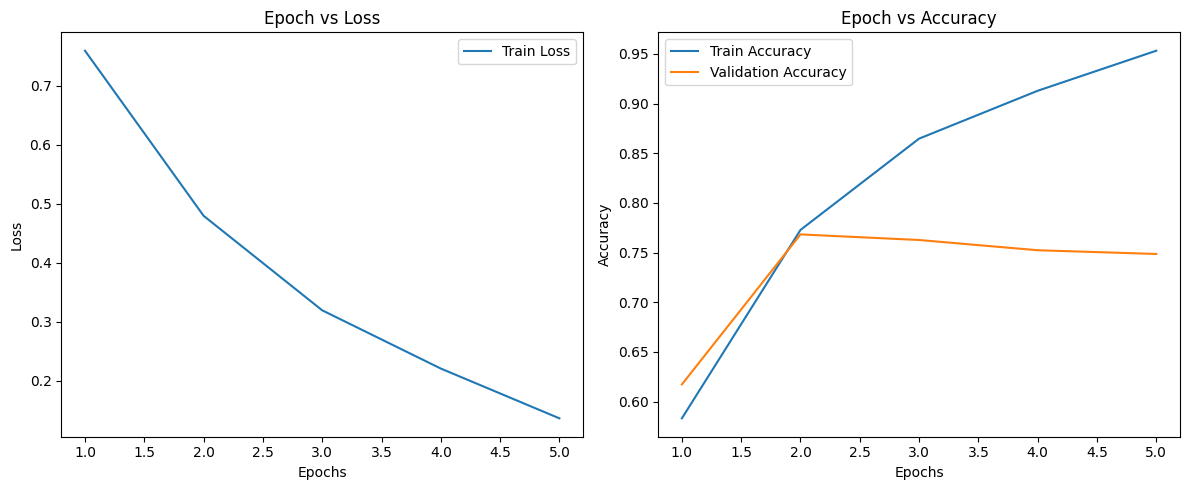

In [109]:
epochs_cnn = len(train_accuracies)  # Number of epochs actually trained
plot_metrics(epochs_cnn, train_losses, train_accuracies, val_accuracies)

In [110]:
# Evaluate on the test set
test_acc = evaluate_model(best_model_CNN, test_loader)
test_accuracies['CNN'] = test_acc
print(f'Test Accuracy (CNN): {test_acc:.4f}')

Test Accuracy (CNN): 0.7767


### (e) Describe your final improvement strategy in Part 3.5. Report the accuracy on the test set using your improved model.

### Ensemble Methods

This setup aggregates the model predictions by averaging the class probabilities across each model, then assigns the final prediction based on the highest average probability. This approach should increase overall stability and potentially improve the test accuracy of your sentiment classification task by leveraging the diverse perspectives of different models.

In [111]:
def ensemble_predict(models, data_loader):
    all_probs = []

    # Collect prediction probabilities from each model
    for model in models:
        model.eval()  # Set to evaluation mode
        model_probs = []
        with torch.no_grad():
            for inputs, _ in data_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                model_probs.append(torch.softmax(outputs, dim=1).cpu().numpy())
        all_probs.append(np.vstack(model_probs))

    # Average the probabilities across models
    avg_probs = np.mean(all_probs, axis=0)
    final_preds = np.argmax(avg_probs, axis=1)
    
    return final_preds

In [112]:
def compute_ensemble_accuracy(models, test_loader, test_labels):
    # Get ensemble predictions
    ensemble_preds = ensemble_predict(models, test_loader)

    # Calculate accuracy
    accuracy = np.mean(ensemble_preds == test_labels.cpu().numpy())
    print(f'Test Accuracy (Ensemble): {accuracy:.4f}')
    
    return accuracy

In [ ]:
trained_models = [best_model_RNN_update, best_model_biGRU, best_model_biLSTM, best_model_CNN]

# Compute ensemble accuracy on the test set
test_acc = compute_ensemble_accuracy(trained_models, test_loader, test_labels)
test_accuracies['Ensemble'] = test_acc

Test Accuracy (Ensemble): 0.8114


From the test accuracies, we see that when employing **ensemble method with soft voting (probability averaging)** gives us a higher test accuracy compared to the test accuracies of each individual model.

###  (f) Compare the results across different solutions above and describe your observations with possible discussions.

In [127]:
test_accuracies

{'RNN Last Hidden State': 0.49906191369606,
 'RNN Max Pooling': 0.7570356472795498,
 'RNN Average Pooling': 0.7054409005628518,
 'RNN (Update Word Embeddings)': 0.7964352720450282,
 'RNN (Handle OOV)': 0.7589118198874296,
 'RNN (Handle OOV with Word Embeddings Update)': 0.7636022514071295,
 'biLSTM': 0.7917448405253283,
 'biGRU': 0.8030018761726079,
 'CNN': 0.776735459662289,
 'Ensemble': 0.8114446529080676}